In [626]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier
import tqdm
from scipy.interpolate import griddata

In [627]:
# Function to initialize ratings
def initialize_ratings(df_results, df_fixtures):
    ratings = {}

    # Iterate over teams in the results data
    teams = set(df_results['home_team']).union(set(df_results['away_team'])).union(set(df_fixtures['home_team'])).union(set(df_fixtures['away_team']))
    for team in teams:
        # Initialize ratings for each team
        ratings[team] = {
            'brH': 0.0,
            'brA': 0.0,
            'continuous_overunderperformances': 0
        }
    #print('Teams:', teams, end='\n\n')
    return ratings

In [760]:
# Function to update ratings based on results data
def update_ratings_multiple_games(df_results, ratings, learning_rate_lambda, learning_rate_gamma):

    games_with_rating = []
    training_games = []

    # Iterate over each match in the results data
    for index, row in df_results.iterrows():

        if index > 2500:
            #add current game to training data
            training_games.append({
                "brH_x": ratings[row["home_team"]]["brH"],
                "brA_x": ratings[row["home_team"]]["brA"],
                "prH_x": calculate_provisional_ratings(ratings, row["home_team"])[0],
                "prA_x": calculate_provisional_ratings(ratings, row["home_team"])[1],
                "brH_y": ratings[row["away_team"]]["brH"],
                "brA_y": ratings[row["away_team"]]["brA"],
                "prH_y": calculate_provisional_ratings(ratings, row["away_team"])[0],
                "prA_y": calculate_provisional_ratings(ratings, row["away_team"])[1],
                "rating_difference": (calculate_provisional_ratings(ratings, row["home_team"])[0]) - (calculate_provisional_ratings(ratings, row["away_team"])[1]),
                "home_goals": row["home_goals"],
                "away_goals": row["away_goals"],
                "result": row["result"]
            })


        if np.isnan(ratings[row['home_team']]['brH']):
            print("error")
            break

        #print("Game Nr:", index)

        #time.sleep(0.001)

        ratings = update_ratings_single_game(row['home_team'], row['away_team'], row['home_goals'], row['away_goals'], ratings, learning_rate_lambda, learning_rate_gamma)

        games_with_rating.append({
            "team": row["home_team"],
            "home_rating": ratings[row["home_team"]]["brH"],
            "away_rating": ratings[row["home_team"]]["brA"],
            "continuous_overunderperformances": ratings[row["home_team"]]["continuous_overunderperformances"],
        })

        games_with_rating.append({
            "team": row["away_team"],
            "home_rating": ratings[row["away_team"]]["brH"],
            "away_rating": ratings[row["away_team"]]["brA"],
            "continuous_overunderperformances": ratings[row["away_team"]]["continuous_overunderperformances"],
        })

    return ratings, games_with_rating, training_games

In [761]:
# Function to update ratings based on results data
def update_ratings_single_game(home_team, away_team, home_goals, away_goals, ratings, learning_rate_lambda, learning_rate_gamma):

    #lambda: Determines to what extent the new match results influence the team ratings (could be improved to include temporal difference between matches)
    #learning_rate_lambda = 0.054

    #psi: diminish the impact each additional goal difference error has on team ratings
    diminishing_function_psi = lambda error: 3 * np.log10(1 + error)

    #gamma: determines to what extent performances at the home grounds influence away team ratings and vice versa
    #learning_rate_gamma = 0.79

    #print(home_team, "-", away_team, home_goals, ":", away_goals)


    observed_goal_difference = home_goals - away_goals
    #print("Observed Goal Difference:", observed_goal_difference)

    #Calculate expected goals for home team
    #expected_goal_x = round((10 ** (abs(ratings[home_team]['brH']) / 3)) - 1,5)
    expected_goal_x_temp = abs(ratings[home_team]['brH']) / 3
    expected_goal_x = np.sign(ratings[home_team]['brH']) * (np.power(10, expected_goal_x_temp) - 1)
    #print("Expected Goals x:", expected_goal_x)

    # Calculate expected goals for away team
    #expected_goal_y = round((10 ** (abs(ratings[away_team]['brA']) / 3)) - 1,5)
    expected_goal_y_temp = abs(ratings[away_team]['brA']) / 3
    expected_goal_y = np.sign(ratings[away_team]['brA']) * (np.power(10, expected_goal_y_temp) - 1)
    #print("Expected Goals y:", expected_goal_y)

    # Calculate expected goal difference based on ratings
    expected_goal_difference = expected_goal_x - expected_goal_y
    #print("Expected Goal Difference:", expected_goal_difference)

    # Calculate the error between observed and expected goal difference
    error = abs(observed_goal_difference - expected_goal_difference)
    #print("error:", error)

    psi_temp = diminishing_function_psi(error)

    # Diminish the impact of the goal difference error for both teams x and y respectively
    if (expected_goal_difference < observed_goal_difference):
        diminishing_function_psi_x = psi_temp
        diminishing_function_psi_y = -psi_temp
    else:
        diminishing_function_psi_x = -psi_temp
        diminishing_function_psi_y = psi_temp
    #print("Diminishing Function psi x:", diminishing_function_psi_x)
    #print("Diminishing Function psi y:", diminishing_function_psi_y)

    # Update the home team x background ratings
    previous_home_rating_x = ratings[home_team]['brH']
    previous_away_rating_x = ratings[home_team]['brA']
    #print("Old brH x:", previous_home_rating_x)
    #print("Old brA x:", previous_away_rating_x)

    ratings[home_team]['brH'] = previous_home_rating_x + diminishing_function_psi_x * learning_rate_lambda
    ratings[home_team]['brA'] = previous_away_rating_x + (ratings[home_team]['brH'] - previous_home_rating_x) * learning_rate_gamma
    #print("New brH x:", ratings[home_team]['brH'])
    #print("New brA x:", ratings[home_team]['brA'])

    # Update the away team y background ratings
    previous_home_rating_y = ratings[away_team]['brH']
    previous_away_rating_y = ratings[away_team]['brA']
    #print("Old brH y:", previous_home_rating_y)
    #print("Old brA y:", previous_away_rating_y)

    ratings[away_team]['brA'] = previous_away_rating_y + diminishing_function_psi_y * learning_rate_lambda
    ratings[away_team]['brH'] = previous_home_rating_y + (ratings[away_team]['brA'] - previous_away_rating_y) * learning_rate_gamma
    #print("New brH y:", ratings[away_team]['brH'])
    #print("New brA y:", ratings[away_team]['brA'])

    #print("Old overunderperformance x:", ratings[home_team]['continuous_overunderperformances'])
    #print("Old overunderperformance y:", ratings[away_team]['continuous_overunderperformances'])

    # Update the continuous over/underperformances for the home team
    if (observed_goal_difference > expected_goal_difference):
        ratings[home_team]['continuous_overunderperformances'] = max(1, ratings[home_team]['continuous_overunderperformances'] + 1)
        ratings[away_team]['continuous_overunderperformances'] = min(-1, ratings[away_team]['continuous_overunderperformances'] - 1)
    elif (observed_goal_difference < expected_goal_difference):
        ratings[home_team]['continuous_overunderperformances'] = min(-1, ratings[home_team]['continuous_overunderperformances'] - 1)
        ratings[away_team]['continuous_overunderperformances'] = max(1, ratings[away_team]['continuous_overunderperformances'] + 1)
    else:
        ratings[home_team]['continuous_overunderperformances'] = 0
        ratings[away_team]['continuous_overunderperformances'] = 0

    #print("New overunderperformance x:", ratings[home_team]['continuous_overunderperformances'])
    #print("New overunderperformance y:", ratings[away_team]['continuous_overunderperformances'], end='\n\n')

    return ratings


In [762]:
def calculate_provisional_ratings(ratings, team):

    #phi: Represents the number of continuous performances, above or below expectations, which do not trigger the form factor
    form_threshold_phi = 1

    #mu: represents the rating difference used to establish provisional ratings from background ratings
    rating_impact_mu = 0.01

    #delta: the level by which rating impact μ diminishes with each additional continuous over/under-performance
    diminishing_factor_delta = 2.5

    brH = ratings[team]['brH']  # Background rating home
    brA = ratings[team]['brA']  # Background rating away
    prH = brH
    prA = brA

    return prH, prA

    if abs(ratings[team]['continuous_overunderperformances']) < 2:
        return prH, prA

    # Calculate performance factor for home team x
    a = abs(ratings[team]['continuous_overunderperformances']) - form_threshold_phi
    b = a ** diminishing_factor_delta
    form_factor_home = a / b

    # Calculate provisional rating of the team
    if (ratings[team]['continuous_overunderperformances'] > form_threshold_phi):
        prH = brH + rating_impact_mu * form_factor_home
        prA = brA + rating_impact_mu * form_factor_home
    if (ratings[team]['continuous_overunderperformances'] < -form_threshold_phi):
        prH = brH - rating_impact_mu * form_factor_home
        prA = brA - rating_impact_mu * form_factor_home

    #return prH, prA

In [763]:
def calculate_probabilities(features):
    # Load the model and label encoder
    model = joblib.load('../Models/model.pkl')

    # Now you can predict probabilities for a new game:
    new_game_rating_difference = np.array([features])
    probabilities = model.predict_proba(new_game_rating_difference)
    return probabilities[0]

In [764]:
# Function to calculate the rating difference between two teams
def calculate_rating_difference(home_team, away_team, ratings):

    # Calculate home team rating
    home_rating_x = ratings[home_team]['brH']
    if (abs(ratings[home_team]['continuous_overunderperformances']) > 1):
        provisional_ratings_x = calculate_provisional_ratings(ratings, home_team)
        home_rating_x = provisional_ratings_x[0]

    # Calculate away team rating
    away_rating_y = ratings[away_team]['brA']
    if (abs(ratings[away_team]['continuous_overunderperformances']) > 1):
        provisional_ratings_y = calculate_provisional_ratings(ratings, away_team)
        away_rating_y = provisional_ratings_y[1]

    # Calculate rating difference
    rating_difference = home_rating_x - away_rating_y

    return rating_difference

In [765]:
def predict_outcomes(df_fixtures, ratings, learning_rate_lambda, learning_rate_gamma):
    all_rps = []
    league_table = pd.DataFrame(columns=['team', 'games_played', 'points'])

    for index, row in df_fixtures.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        rating_difference = calculate_rating_difference(home_team, away_team, ratings)
        """
        prH_x = calculate_provisional_ratings(ratings, home_team)[0]
        prA_x = calculate_provisional_ratings(ratings, away_team)[1]
        prH_y = calculate_provisional_ratings(ratings, home_team)[0]
        prA_y = calculate_provisional_ratings(ratings, away_team)[1]
        """

        #features = [prH_x, prA_x, prH_y, prA_y]
        features = [rating_difference]

        away_win_prob, draw_prob, home_win_prob = calculate_probabilities(features)

        home_goals = int(row['home_goals'])
        away_goals = int(row['away_goals'])

        """
        print(f"{home_team} - {away_team} {home_goals}:{away_goals}")
        print(f"Home Win Prob: {home_win_prob}")
        print(f"Draw Prob: {draw_prob}")
        print(f"Away Win Prob: {away_win_prob}")
        """

        # Call Ranked Probability Score function
        probs = [home_win_prob, draw_prob, away_win_prob]
        if row["result"] == "H":
            outcome = [1, 0, 0]
        elif row["result"] == "D":
            outcome = [0, 1, 0]
        else:
            outcome = [0, 0, 1]

        rps_score = rps(probs, outcome)
        #print("RPS Score:", rps_score, end='\n\n')
        all_rps.append(rps_score)

         # Compute expected points for both teams
        home_points = home_win_prob * 3 + draw_prob
        away_points = away_win_prob * 3 + draw_prob

        # Update league table
        league_table = update_league_table(league_table, home_team, away_team, home_win_prob, draw_prob, away_win_prob)

        ratings = update_ratings_single_game(home_team, away_team, row['home_goals'], row['away_goals'], ratings, learning_rate_lambda, learning_rate_gamma)

    print("Average RPS Score:", np.mean(all_rps), end='\n\n')

    league_table = league_table.sort_values(['points', 'games_played'], ascending=False)
    league_table = league_table.reset_index(drop=True)


    return all_rps, league_table


In [766]:
def update_league_table(league_table, home_team, away_team, home_win_prob, draw_prob, away_win_prob):
    # Calculate points based on probabilities
    home_points = home_win_prob * 3 + draw_prob * 1
    away_points = away_win_prob * 3 + draw_prob * 1

    # Home team update
    if home_team in league_table['team'].values:
        league_table.loc[league_table['team'] == home_team, 'games_played'] += 1
        league_table.loc[league_table['team'] == home_team, 'points'] += home_points
    else:
        df_home = pd.DataFrame({'team': [home_team], 'games_played': [1], 'points': [home_points]})
        league_table = pd.concat([league_table, df_home], ignore_index=True)

    # Away team update
    if away_team in league_table['team'].values:
        league_table.loc[league_table['team'] == away_team, 'games_played'] += 1
        league_table.loc[league_table['team'] == away_team, 'points'] += away_points
    else:
        df_away = pd.DataFrame({'team': [away_team], 'games_played': [1], 'points': [away_points]})
        league_table = pd.concat([league_table, df_away], ignore_index=True)

    return league_table

In [767]:
def rps(probs, outcome):
    cum_probs = np.cumsum(probs)
    cum_outcomes = np.cumsum(outcome)

    sum_rps = 0
    for i in range(len(outcome)):
        sum_rps+= (cum_probs[i] - cum_outcomes[i])**2

    return sum_rps/(len(outcome)-1)

In [768]:

def train_model(df_train):

    # Create Logistic Regression model
    #model = LogisticRegression(solver="saga", penalty="l2")  # 'ovr' stands for One-Vs-Rest
    model = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(5, 2), random_state=23, max_iter=1000)

    # Reshape rating_difference to 2D array for model fitting
    #X = df_train[['prH_x', 'prA_x', "prH_y", "prA_y"]].values
    X = df_train["rating_difference"].values.reshape(-1, 1)
    y = df_train['result']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.00001, random_state=42)

    # Fit the model with the training data
    model.fit(X_train, y_train)

    # Save the model and label encoder
    joblib.dump(model, '../Models/model.pkl')

    # Evaluate the model on the test set
    score = model.score(X_test, y_test)
    #print(f'Model accuracy: {score*100:.2f}%')

    return model


Average RPS Score: 0.18609362719535602



''

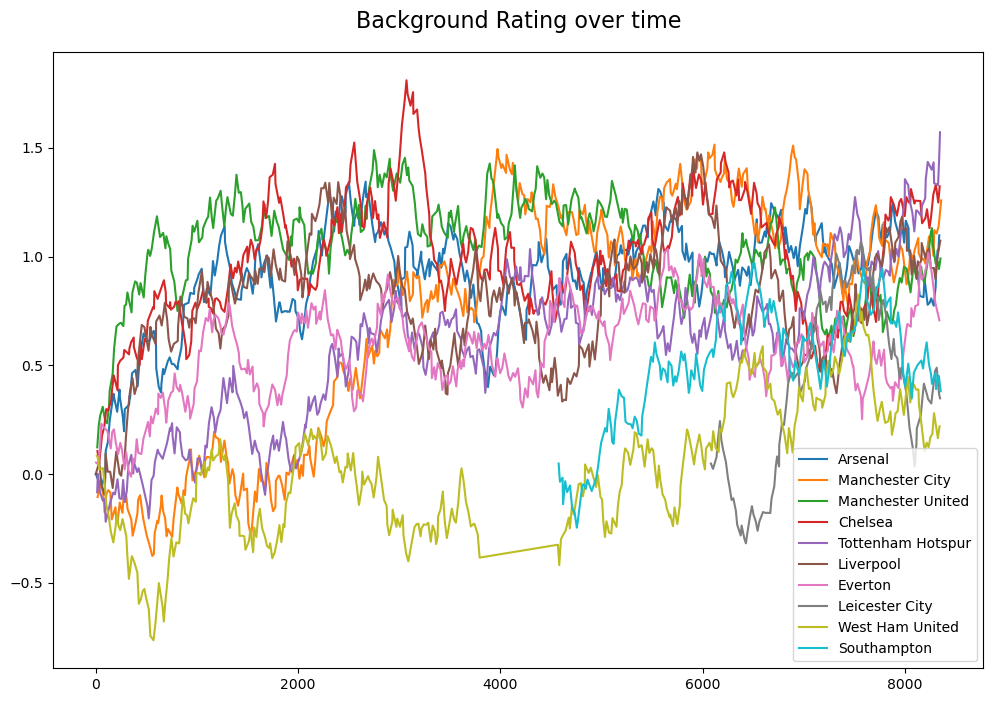

In [769]:

# Load the results data file for seasons 2006-07 to 2016-17
df_results = pd.read_csv('../data/results.csv')

# Load the fixtures data file for the season 2017-18
df_fixtures = pd.read_csv('../data/results201718.csv')

# Initialize ratings based on the results data
ratings = initialize_ratings(df_results, df_fixtures)

learning_rate_lambda = 0.06
learning_rate_gamma = 0.95

# Update ratings based on the results data here
ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, learning_rate_lambda, learning_rate_gamma)
#model.C_


plt.figure(figsize=(12, 8))
plt.annotate("Background Rating over time", (0.5, 1.05), xycoords='axes fraction', ha='center', va='center', size=16)
df_ratings = pd.DataFrame(games_with_ratings)
teams = ["Arsenal", "Manchester City", "Manchester United", "Chelsea", "Tottenham Hotspur", "Liverpool", "Everton", "Leicester City", "West Ham United", "Southampton"]
#for team in df_ratings["team"].unique()[:10]:
for team in teams:
    per_team = df_ratings.loc[df_ratings["team"] == team]
    plt.plot((per_team["home_rating"] + per_team["away_rating"]) / 2, label=team)
plt.legend()
plt.savefig("../images/ratings_over_time.png", dpi=300)

df_train = pd.DataFrame(training_games)

df_train.to_csv("../data/train.csv", index=False)

model = train_model(df_train)

# Predict the probabilities of home win, draw and away win for the fixtures data
all_rps, league_table = predict_outcomes(df_fixtures, ratings, learning_rate_lambda, learning_rate_gamma)

;

                        team games_played     points
1            Manchester City           38  78.002096
2          Tottenham Hotspur           38  75.420580
3          Manchester United           38  73.872243
4                    Chelsea           38  73.674294
5                  Liverpool           38  73.634933
6                    Arsenal           38  70.437003
7             Leicester City           38  51.960128
8                    Everton           38  50.823369
9                    Burnley           38  48.424749
10           AFC Bournemouth           38  44.747032
11               Southampton           38  44.706354
12          Newcastle United           38  43.624289
13           West Ham United           38  43.073561
14            Crystal Palace           38  42.192773
15              Swansea City           38  41.626480
16      West Bromwich Albion           38  39.783804
17                Stoke City           38  39.217722
18  Brighton and Hove Albion           38  39.

''

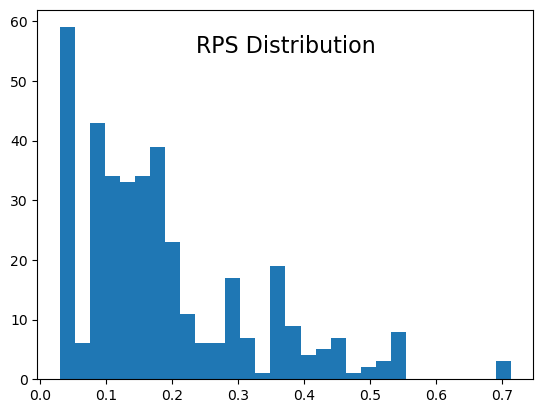

In [770]:

plt.annotate("RPS Distribution", (0.5, 0.9), xycoords='axes fraction', ha='center', va='center', size=16)
plt.hist(all_rps, bins=30)
plt.savefig("../images/rps_distribution.png", dpi=300)


league_table.index = league_table.index + 1
print(league_table)
league_table.index = league_table.index - 1

"""
for team, team_ratings in ratings.items():
    print(f"Team: {team}")
    print(f"Background Rating Home: {team_ratings['brH']}")
    print(f"Background Rating Away: {team_ratings['brA']}")
    print(f"Continuous Over/Underperformances: {team_ratings['continuous_overunderperformances']}")
    print()
"""
;

  0%|          | 1/400 [00:02<13:59,  2.10s/it]

Average RPS Score: 0.19420941134725608



  0%|          | 2/400 [00:03<12:34,  1.89s/it]

Average RPS Score: 0.19396537186717935



  1%|          | 3/400 [00:05<12:09,  1.84s/it]

Average RPS Score: 0.19311839391233748



  1%|          | 4/400 [00:07<12:06,  1.83s/it]

Average RPS Score: 0.19403544730764025



  1%|▏         | 5/400 [00:09<11:46,  1.79s/it]

Average RPS Score: 0.19254314101064585



  2%|▏         | 6/400 [00:10<11:32,  1.76s/it]

Average RPS Score: 0.19267602932239838



  2%|▏         | 7/400 [00:12<11:25,  1.74s/it]

Average RPS Score: 0.19299198175337035



  2%|▏         | 8/400 [00:14<11:14,  1.72s/it]

Average RPS Score: 0.19265110394183302



  2%|▏         | 9/400 [00:15<11:16,  1.73s/it]

Average RPS Score: 0.19231431094096813



  2%|▎         | 10/400 [00:17<11:18,  1.74s/it]

Average RPS Score: 0.19223763672702587



  3%|▎         | 11/400 [00:19<11:10,  1.72s/it]

Average RPS Score: 0.19104612442123856



  3%|▎         | 12/400 [00:21<11:09,  1.73s/it]

Average RPS Score: 0.1906800780667251



  3%|▎         | 13/400 [00:22<11:17,  1.75s/it]

Average RPS Score: 0.19058006861584453



  4%|▎         | 14/400 [00:24<11:16,  1.75s/it]

Average RPS Score: 0.19051120290572895



  4%|▍         | 15/400 [00:26<11:08,  1.74s/it]

Average RPS Score: 0.19288648881525083



  4%|▍         | 16/400 [00:28<11:01,  1.72s/it]

Average RPS Score: 0.1924767545866747



  4%|▍         | 17/400 [00:29<10:55,  1.71s/it]

Average RPS Score: 0.19311118781967915



  4%|▍         | 18/400 [00:31<10:50,  1.70s/it]

Average RPS Score: 0.19308712614469048



  5%|▍         | 19/400 [00:33<10:58,  1.73s/it]

Average RPS Score: 0.1909547823770805



  5%|▌         | 20/400 [00:34<10:52,  1.72s/it]

Average RPS Score: 0.19164321775859997



  5%|▌         | 21/400 [00:36<10:50,  1.72s/it]

Average RPS Score: 0.1937991263897301



  6%|▌         | 22/400 [00:38<10:41,  1.70s/it]

Average RPS Score: 0.19328878579707315



  6%|▌         | 23/400 [00:40<10:52,  1.73s/it]

Average RPS Score: 0.1928392482257594



  6%|▌         | 24/400 [00:41<10:50,  1.73s/it]

Average RPS Score: 0.19280660350814025



  6%|▋         | 25/400 [00:43<10:49,  1.73s/it]

Average RPS Score: 0.19251816875636896



  6%|▋         | 26/400 [00:45<10:40,  1.71s/it]

Average RPS Score: 0.1925887961720824



  7%|▋         | 27/400 [00:47<10:45,  1.73s/it]

Average RPS Score: 0.19285118686977848



  7%|▋         | 28/400 [00:48<10:36,  1.71s/it]

Average RPS Score: 0.19228418456067298



  7%|▋         | 29/400 [00:50<10:30,  1.70s/it]

Average RPS Score: 0.19222274868186678



  8%|▊         | 30/400 [00:52<10:34,  1.71s/it]

Average RPS Score: 0.1920280267476249



  8%|▊         | 31/400 [00:53<10:29,  1.71s/it]

Average RPS Score: 0.19084557449231487



  8%|▊         | 32/400 [00:55<10:24,  1.70s/it]

Average RPS Score: 0.19037788881951181



  8%|▊         | 33/400 [00:57<10:27,  1.71s/it]

Average RPS Score: 0.19101342868072896



  8%|▊         | 34/400 [00:58<10:26,  1.71s/it]

Average RPS Score: 0.19200024464210996



  9%|▉         | 35/400 [01:00<10:23,  1.71s/it]

Average RPS Score: 0.19070088021902026



  9%|▉         | 36/400 [01:02<10:32,  1.74s/it]

Average RPS Score: 0.19275595692712333



  9%|▉         | 37/400 [01:04<10:33,  1.75s/it]

Average RPS Score: 0.19289011302371012



 10%|▉         | 38/400 [01:05<10:27,  1.73s/it]

Average RPS Score: 0.1908525837299068



 10%|▉         | 39/400 [01:07<10:26,  1.73s/it]

Average RPS Score: 0.19141439184367268



 10%|█         | 40/400 [01:09<10:18,  1.72s/it]

Average RPS Score: 0.19128404882908612



 10%|█         | 41/400 [01:11<10:15,  1.71s/it]

Average RPS Score: 0.19305924627091062



 10%|█         | 42/400 [01:12<10:14,  1.72s/it]

Average RPS Score: 0.1930433095468764



 11%|█         | 43/400 [01:14<10:08,  1.71s/it]

Average RPS Score: 0.19283906527670427



 11%|█         | 44/400 [01:16<10:09,  1.71s/it]

Average RPS Score: 0.19299220772230197



 11%|█▏        | 45/400 [01:17<10:10,  1.72s/it]

Average RPS Score: 0.1924151709171438



 12%|█▏        | 46/400 [01:19<10:03,  1.70s/it]

Average RPS Score: 0.1925662130611732



 12%|█▏        | 47/400 [01:21<10:07,  1.72s/it]

Average RPS Score: 0.1924761293370961



 12%|█▏        | 48/400 [01:23<10:10,  1.73s/it]

Average RPS Score: 0.19222161521524694



 12%|█▏        | 49/400 [01:24<10:02,  1.72s/it]

Average RPS Score: 0.19129056227735727



 12%|█▎        | 50/400 [01:26<10:02,  1.72s/it]

Average RPS Score: 0.19097388858911654



 13%|█▎        | 51/400 [01:28<10:04,  1.73s/it]

Average RPS Score: 0.19081385026442743



 13%|█▎        | 52/400 [01:30<10:05,  1.74s/it]

Average RPS Score: 0.1901797816413458



 13%|█▎        | 53/400 [01:31<09:58,  1.72s/it]

Average RPS Score: 0.18979692758650596



 14%|█▎        | 54/400 [01:33<09:56,  1.72s/it]

Average RPS Score: 0.18982019221454344



 14%|█▍        | 55/400 [01:35<09:59,  1.74s/it]

Average RPS Score: 0.18987062093426338



 14%|█▍        | 56/400 [01:36<09:59,  1.74s/it]

Average RPS Score: 0.19030383368007597



 14%|█▍        | 57/400 [01:38<09:53,  1.73s/it]

Average RPS Score: 0.19064416889335054



 14%|█▍        | 58/400 [01:40<09:50,  1.73s/it]

Average RPS Score: 0.19100839488073426



 15%|█▍        | 59/400 [01:42<09:57,  1.75s/it]

Average RPS Score: 0.19065267586162205



 15%|█▌        | 60/400 [01:43<09:56,  1.75s/it]

Average RPS Score: 0.19291232002855624



 15%|█▌        | 61/400 [01:45<09:48,  1.74s/it]

Average RPS Score: 0.19316063272680206



 16%|█▌        | 62/400 [01:47<09:49,  1.74s/it]

Average RPS Score: 0.1935091221536825



 16%|█▌        | 63/400 [01:49<09:39,  1.72s/it]

Average RPS Score: 0.19263228998146723



 16%|█▌        | 64/400 [01:50<09:36,  1.72s/it]

Average RPS Score: 0.1928492354396961



 16%|█▋        | 65/400 [01:52<09:34,  1.72s/it]

Average RPS Score: 0.19248120814981598



 16%|█▋        | 66/400 [01:54<09:30,  1.71s/it]

Average RPS Score: 0.1925628563741512



 17%|█▋        | 67/400 [01:55<09:23,  1.69s/it]

Average RPS Score: 0.19228316455502623



 17%|█▋        | 68/400 [01:57<09:19,  1.69s/it]

Average RPS Score: 0.1922733799644775



 17%|█▋        | 69/400 [01:59<09:26,  1.71s/it]

Average RPS Score: 0.19206990101742688



 18%|█▊        | 70/400 [02:01<09:26,  1.72s/it]

Average RPS Score: 0.1906637494076488



 18%|█▊        | 71/400 [02:02<09:27,  1.73s/it]

Average RPS Score: 0.19032031177442915



 18%|█▊        | 72/400 [02:04<09:23,  1.72s/it]

Average RPS Score: 0.18984952998890417



 18%|█▊        | 73/400 [02:06<09:25,  1.73s/it]

Average RPS Score: 0.1899774284168234



 18%|█▊        | 74/400 [02:07<09:23,  1.73s/it]

Average RPS Score: 0.18951301593442524



 19%|█▉        | 75/400 [02:09<09:27,  1.75s/it]

Average RPS Score: 0.18949462993792654



 19%|█▉        | 76/400 [02:11<09:27,  1.75s/it]

Average RPS Score: 0.19027098074373686



 19%|█▉        | 77/400 [02:13<09:22,  1.74s/it]

Average RPS Score: 0.19056245821958034



 20%|█▉        | 78/400 [02:15<09:24,  1.75s/it]

Average RPS Score: 0.19104927097433091



 20%|█▉        | 79/400 [02:16<09:22,  1.75s/it]

Average RPS Score: 0.19111715149395322



 20%|██        | 80/400 [02:18<09:36,  1.80s/it]

Average RPS Score: 0.1907293154089258



 20%|██        | 81/400 [02:20<09:24,  1.77s/it]

Average RPS Score: 0.19265209472144207



 20%|██        | 82/400 [02:22<09:21,  1.77s/it]

Average RPS Score: 0.19316657446502666



 21%|██        | 83/400 [02:23<09:15,  1.75s/it]

Average RPS Score: 0.19248711972859098



 21%|██        | 84/400 [02:25<09:07,  1.73s/it]

Average RPS Score: 0.192738505241309



 21%|██▏       | 85/400 [02:27<09:06,  1.73s/it]

Average RPS Score: 0.19281954241254395



 22%|██▏       | 86/400 [02:29<09:04,  1.73s/it]

Average RPS Score: 0.19250779310858535



 22%|██▏       | 87/400 [02:30<09:02,  1.73s/it]

Average RPS Score: 0.19220598027172145



 22%|██▏       | 88/400 [02:32<09:01,  1.73s/it]

Average RPS Score: 0.19217639233258768



 22%|██▏       | 89/400 [02:34<08:53,  1.72s/it]

Average RPS Score: 0.1920470953841162



 22%|██▎       | 90/400 [02:35<08:56,  1.73s/it]

Average RPS Score: 0.19164671119865428



 23%|██▎       | 91/400 [02:37<08:57,  1.74s/it]

Average RPS Score: 0.19030085537476277



 23%|██▎       | 92/400 [02:39<08:51,  1.73s/it]

Average RPS Score: 0.18959392215661916



 23%|██▎       | 93/400 [02:41<08:52,  1.73s/it]

Average RPS Score: 0.18930553721431698



 24%|██▎       | 94/400 [02:42<08:50,  1.73s/it]

Average RPS Score: 0.18934360555702281



 24%|██▍       | 95/400 [02:44<09:12,  1.81s/it]

Average RPS Score: 0.18970156080734055



 24%|██▍       | 96/400 [02:46<09:03,  1.79s/it]

Average RPS Score: 0.19001679501663724



 24%|██▍       | 97/400 [02:48<08:57,  1.77s/it]

Average RPS Score: 0.19023139995568972



 24%|██▍       | 98/400 [02:50<08:48,  1.75s/it]

Average RPS Score: 0.19064296869259625



 25%|██▍       | 99/400 [02:51<08:42,  1.74s/it]

Average RPS Score: 0.1906254503698232



 25%|██▌       | 100/400 [02:53<08:35,  1.72s/it]

Average RPS Score: 0.19125986481251825



 25%|██▌       | 101/400 [02:55<08:32,  1.71s/it]

Average RPS Score: 0.19238969083245866



 26%|██▌       | 102/400 [02:56<08:29,  1.71s/it]

Average RPS Score: 0.19293182775237722



 26%|██▌       | 103/400 [02:58<08:26,  1.71s/it]

Average RPS Score: 0.19239221659211506



 26%|██▌       | 104/400 [03:00<08:24,  1.70s/it]

Average RPS Score: 0.19265476078399343



 26%|██▋       | 105/400 [03:01<08:23,  1.71s/it]

Average RPS Score: 0.1925979223927892



 26%|██▋       | 106/400 [03:03<08:23,  1.71s/it]

Average RPS Score: 0.19266536000556292



 27%|██▋       | 107/400 [03:05<08:24,  1.72s/it]

Average RPS Score: 0.19216494108309537



 27%|██▋       | 108/400 [03:07<08:19,  1.71s/it]

Average RPS Score: 0.1920519382058216



 27%|██▋       | 109/400 [03:08<08:15,  1.70s/it]

Average RPS Score: 0.1919375322925285



 28%|██▊       | 110/400 [03:10<08:19,  1.72s/it]

Average RPS Score: 0.19003035231467233



 28%|██▊       | 111/400 [03:12<08:17,  1.72s/it]

Average RPS Score: 0.19006680172875437



 28%|██▊       | 112/400 [03:13<08:15,  1.72s/it]

Average RPS Score: 0.18980072261250314



 28%|██▊       | 113/400 [03:15<08:11,  1.71s/it]

Average RPS Score: 0.1892344641856575



 28%|██▊       | 114/400 [03:17<08:08,  1.71s/it]

Average RPS Score: 0.18958817206475725



 29%|██▉       | 115/400 [03:19<08:14,  1.74s/it]

Average RPS Score: 0.18925866238604772



 29%|██▉       | 116/400 [03:20<08:12,  1.73s/it]

Average RPS Score: 0.18984108061067997



 29%|██▉       | 117/400 [03:22<08:13,  1.74s/it]

Average RPS Score: 0.19043765293299728



 30%|██▉       | 118/400 [03:24<08:08,  1.73s/it]

Average RPS Score: 0.19026805206970554



 30%|██▉       | 119/400 [03:26<08:06,  1.73s/it]

Average RPS Score: 0.19069053602345523



 30%|███       | 120/400 [03:27<08:10,  1.75s/it]

Average RPS Score: 0.1908856797084856



 30%|███       | 121/400 [03:29<08:07,  1.75s/it]

Average RPS Score: 0.19189141609003166



 30%|███       | 122/400 [03:31<08:03,  1.74s/it]

Average RPS Score: 0.19266551273687302



 31%|███       | 123/400 [03:33<08:02,  1.74s/it]

Average RPS Score: 0.19264910584933917



 31%|███       | 124/400 [03:34<07:56,  1.73s/it]

Average RPS Score: 0.19262947718247603



 31%|███▏      | 125/400 [03:36<07:52,  1.72s/it]

Average RPS Score: 0.1927323511071934



 32%|███▏      | 126/400 [03:38<07:49,  1.71s/it]

Average RPS Score: 0.19236973503971672



 32%|███▏      | 127/400 [03:39<07:47,  1.71s/it]

Average RPS Score: 0.19211209912069444



 32%|███▏      | 128/400 [03:41<07:44,  1.71s/it]

Average RPS Score: 0.19194431175470006



 32%|███▏      | 129/400 [03:43<07:42,  1.71s/it]

Average RPS Score: 0.19236634336804756



 32%|███▎      | 130/400 [03:45<07:47,  1.73s/it]

Average RPS Score: 0.18984761570669392



 33%|███▎      | 131/400 [03:46<07:45,  1.73s/it]

Average RPS Score: 0.19134940904986344



 33%|███▎      | 132/400 [03:48<07:43,  1.73s/it]

Average RPS Score: 0.19139574679000282



 33%|███▎      | 133/400 [03:50<07:41,  1.73s/it]

Average RPS Score: 0.1888224536933624



 34%|███▎      | 134/400 [03:51<07:34,  1.71s/it]

Average RPS Score: 0.18893218295582498



 34%|███▍      | 135/400 [03:53<07:33,  1.71s/it]

Average RPS Score: 0.1890642650429311



 34%|███▍      | 136/400 [03:55<07:29,  1.70s/it]

Average RPS Score: 0.18998174145408514



 34%|███▍      | 137/400 [03:57<07:27,  1.70s/it]

Average RPS Score: 0.19020580138912427



 34%|███▍      | 138/400 [03:58<07:26,  1.71s/it]

Average RPS Score: 0.19069760074567615



 35%|███▍      | 139/400 [04:00<07:23,  1.70s/it]

Average RPS Score: 0.1907765480017436



 35%|███▌      | 140/400 [04:02<07:20,  1.70s/it]

Average RPS Score: 0.19209698373142534



 35%|███▌      | 141/400 [04:03<07:20,  1.70s/it]

Average RPS Score: 0.19187760880959312



 36%|███▌      | 142/400 [04:05<07:19,  1.71s/it]

Average RPS Score: 0.19229802600218912



 36%|███▌      | 143/400 [04:07<07:19,  1.71s/it]

Average RPS Score: 0.19223967071932674



 36%|███▌      | 144/400 [04:08<07:18,  1.71s/it]

Average RPS Score: 0.19258520574640847



 36%|███▋      | 145/400 [04:10<07:12,  1.70s/it]

Average RPS Score: 0.19264282838974606



 36%|███▋      | 146/400 [04:12<07:10,  1.70s/it]

Average RPS Score: 0.19252520981847743



 37%|███▋      | 147/400 [04:14<07:09,  1.70s/it]

Average RPS Score: 0.19207706411975345



 37%|███▋      | 148/400 [04:15<07:09,  1.70s/it]

Average RPS Score: 0.19192881902672881



 37%|███▋      | 149/400 [04:17<07:08,  1.71s/it]

Average RPS Score: 0.1918405704730421



 38%|███▊      | 150/400 [04:19<07:06,  1.71s/it]

Average RPS Score: 0.19177114285183236



 38%|███▊      | 151/400 [04:20<07:04,  1.71s/it]

Average RPS Score: 0.19108008985277475



 38%|███▊      | 152/400 [04:22<07:03,  1.71s/it]

Average RPS Score: 0.1911475483380768



 38%|███▊      | 153/400 [04:24<07:04,  1.72s/it]

Average RPS Score: 0.18871675458663392



 38%|███▊      | 154/400 [04:26<07:04,  1.73s/it]

Average RPS Score: 0.1888562255168829



 39%|███▉      | 155/400 [04:27<07:06,  1.74s/it]

Average RPS Score: 0.18900461243897082



 39%|███▉      | 156/400 [04:29<07:02,  1.73s/it]

Average RPS Score: 0.18958934029653637



 39%|███▉      | 157/400 [04:31<07:01,  1.74s/it]

Average RPS Score: 0.19069844820913556



 40%|███▉      | 158/400 [04:33<06:58,  1.73s/it]

Average RPS Score: 0.19063282330915915



 40%|███▉      | 159/400 [04:34<06:55,  1.72s/it]

Average RPS Score: 0.19074043242297045



 40%|████      | 160/400 [04:36<06:54,  1.73s/it]

Average RPS Score: 0.19204862940718517



 40%|████      | 161/400 [04:38<06:52,  1.72s/it]

Average RPS Score: 0.19139230732384438



 40%|████      | 162/400 [04:39<06:48,  1.72s/it]

Average RPS Score: 0.19221512998257495



 41%|████      | 163/400 [04:41<06:48,  1.73s/it]

Average RPS Score: 0.19238253910734895



 41%|████      | 164/400 [04:43<06:50,  1.74s/it]

Average RPS Score: 0.1924585989432753



 41%|████▏     | 165/400 [04:45<06:48,  1.74s/it]

Average RPS Score: 0.19274565342828903



 42%|████▏     | 166/400 [04:46<06:47,  1.74s/it]

Average RPS Score: 0.19249035509476367



 42%|████▏     | 167/400 [04:48<06:46,  1.75s/it]

Average RPS Score: 0.1923041652889895



 42%|████▏     | 168/400 [04:50<06:49,  1.76s/it]

Average RPS Score: 0.1922260228193684



 42%|████▏     | 169/400 [04:52<06:42,  1.74s/it]

Average RPS Score: 0.19233682537308897



 42%|████▎     | 170/400 [04:53<06:38,  1.73s/it]

Average RPS Score: 0.19104596820355982



 43%|████▎     | 171/400 [04:55<06:37,  1.74s/it]

Average RPS Score: 0.1911739722273899



 43%|████▎     | 172/400 [04:57<06:35,  1.73s/it]

Average RPS Score: 0.19103858605933535



 43%|████▎     | 173/400 [04:59<06:32,  1.73s/it]

Average RPS Score: 0.19099981912671832



 44%|████▎     | 174/400 [05:00<06:33,  1.74s/it]

Average RPS Score: 0.190315163382281



 44%|████▍     | 175/400 [05:02<06:32,  1.75s/it]

Average RPS Score: 0.19036654738439338



 44%|████▍     | 176/400 [05:04<06:30,  1.74s/it]

Average RPS Score: 0.18923907081210647



 44%|████▍     | 177/400 [05:06<06:27,  1.74s/it]

Average RPS Score: 0.1906999779391536



 44%|████▍     | 178/400 [05:07<06:27,  1.75s/it]

Average RPS Score: 0.19079971943930807



 45%|████▍     | 179/400 [05:09<06:25,  1.74s/it]

Average RPS Score: 0.1909164544540152



 45%|████▌     | 180/400 [05:11<06:21,  1.73s/it]

Average RPS Score: 0.19118481580785165



 45%|████▌     | 181/400 [05:12<06:18,  1.73s/it]

Average RPS Score: 0.19101095152338185



 46%|████▌     | 182/400 [05:14<06:17,  1.73s/it]

Average RPS Score: 0.1919721865802983



 46%|████▌     | 183/400 [05:16<06:24,  1.77s/it]

Average RPS Score: 0.19236827971293638



 46%|████▌     | 184/400 [05:18<06:19,  1.76s/it]

Average RPS Score: 0.19225691040122986



 46%|████▋     | 185/400 [05:20<06:34,  1.83s/it]

Average RPS Score: 0.19247603350312376



 46%|████▋     | 186/400 [05:22<06:39,  1.87s/it]

Average RPS Score: 0.19238757065459436



 47%|████▋     | 187/400 [05:24<06:46,  1.91s/it]

Average RPS Score: 0.19255995247974872



 47%|████▋     | 188/400 [05:26<06:39,  1.88s/it]

Average RPS Score: 0.19245800745105687



 47%|████▋     | 189/400 [05:27<06:33,  1.86s/it]

Average RPS Score: 0.19196869765765656



 48%|████▊     | 190/400 [05:29<06:23,  1.83s/it]

Average RPS Score: 0.19195115904687873



 48%|████▊     | 191/400 [05:31<06:21,  1.83s/it]

Average RPS Score: 0.1891843473404149



 48%|████▊     | 192/400 [05:33<06:15,  1.81s/it]

Average RPS Score: 0.19081324487402745



 48%|████▊     | 193/400 [05:34<06:08,  1.78s/it]

Average RPS Score: 0.19072900756071973



 48%|████▊     | 194/400 [05:36<06:04,  1.77s/it]

Average RPS Score: 0.1903396838686893



 49%|████▉     | 195/400 [05:38<06:05,  1.78s/it]

Average RPS Score: 0.19028859880443014



 49%|████▉     | 196/400 [05:40<06:02,  1.78s/it]

Average RPS Score: 0.19051349727644176



 49%|████▉     | 197/400 [05:41<05:56,  1.76s/it]

Average RPS Score: 0.19065136276504246



 50%|████▉     | 198/400 [05:43<05:54,  1.76s/it]

Average RPS Score: 0.19076251809627132



 50%|████▉     | 199/400 [05:45<05:53,  1.76s/it]

Average RPS Score: 0.19043870563211315



 50%|█████     | 200/400 [05:47<05:52,  1.76s/it]

Average RPS Score: 0.19058815159604525



 50%|█████     | 201/400 [05:49<05:51,  1.76s/it]

Average RPS Score: 0.19120213404138017



 50%|█████     | 202/400 [05:51<06:05,  1.84s/it]

Average RPS Score: 0.19076747371612374



 51%|█████     | 203/400 [05:52<06:04,  1.85s/it]

Average RPS Score: 0.1919526376882801



 51%|█████     | 204/400 [05:54<05:51,  1.79s/it]

Average RPS Score: 0.19215239932290845



 51%|█████▏    | 205/400 [05:56<05:48,  1.79s/it]

Average RPS Score: 0.1922817006805342



 52%|█████▏    | 206/400 [05:58<05:43,  1.77s/it]

Average RPS Score: 0.1922859543633247



 52%|█████▏    | 207/400 [05:59<05:41,  1.77s/it]

Average RPS Score: 0.19220222725316494



 52%|█████▏    | 208/400 [06:01<05:42,  1.78s/it]

Average RPS Score: 0.19209807582918434



 52%|█████▏    | 209/400 [06:03<05:39,  1.78s/it]

Average RPS Score: 0.19180687747546407



 52%|█████▎    | 210/400 [06:05<05:33,  1.76s/it]

Average RPS Score: 0.1914306935429827



 53%|█████▎    | 211/400 [06:06<05:30,  1.75s/it]

Average RPS Score: 0.19150028816217202



 53%|█████▎    | 212/400 [06:08<05:28,  1.75s/it]

Average RPS Score: 0.19103242642069979



 53%|█████▎    | 213/400 [06:10<05:30,  1.77s/it]

Average RPS Score: 0.1904848475708703



 54%|█████▎    | 214/400 [06:12<05:33,  1.80s/it]

Average RPS Score: 0.19087197575460618



 54%|█████▍    | 215/400 [06:14<05:32,  1.80s/it]

Average RPS Score: 0.19020768706527416



 54%|█████▍    | 216/400 [06:15<05:30,  1.79s/it]

Average RPS Score: 0.19046097544495189



 54%|█████▍    | 217/400 [06:17<05:24,  1.77s/it]

Average RPS Score: 0.190535088732685



 55%|█████▍    | 218/400 [06:19<05:22,  1.77s/it]

Average RPS Score: 0.19114570474076148



 55%|█████▍    | 219/400 [06:21<05:21,  1.77s/it]

Average RPS Score: 0.19138902676987146



 55%|█████▌    | 220/400 [06:22<05:15,  1.75s/it]

Average RPS Score: 0.19072441569906817



 55%|█████▌    | 221/400 [06:24<05:11,  1.74s/it]

Average RPS Score: 0.19103642529293166



 56%|█████▌    | 222/400 [06:26<05:08,  1.73s/it]

Average RPS Score: 0.1915030020860358



 56%|█████▌    | 223/400 [06:28<05:06,  1.73s/it]

Average RPS Score: 0.19210548540530467



 56%|█████▌    | 224/400 [06:29<05:04,  1.73s/it]

Average RPS Score: 0.19212372981645



 56%|█████▋    | 225/400 [06:31<05:01,  1.72s/it]

Average RPS Score: 0.19219742715707985



 56%|█████▋    | 226/400 [06:33<04:59,  1.72s/it]

Average RPS Score: 0.1921322301495071



 57%|█████▋    | 227/400 [06:34<04:59,  1.73s/it]

Average RPS Score: 0.19210414171326817



 57%|█████▋    | 228/400 [06:36<04:59,  1.74s/it]

Average RPS Score: 0.1923293886167141



 57%|█████▋    | 229/400 [06:38<04:56,  1.73s/it]

Average RPS Score: 0.1914836419735951



 57%|█████▊    | 230/400 [06:40<04:52,  1.72s/it]

Average RPS Score: 0.19125580995119212



 58%|█████▊    | 231/400 [06:41<04:49,  1.72s/it]

Average RPS Score: 0.19132544073621902



 58%|█████▊    | 232/400 [06:43<04:47,  1.71s/it]

Average RPS Score: 0.19146176623984637



 58%|█████▊    | 233/400 [06:45<04:44,  1.70s/it]

Average RPS Score: 0.1885575800441447



 58%|█████▊    | 234/400 [06:46<04:43,  1.71s/it]

Average RPS Score: 0.19045195208717977



 59%|█████▉    | 235/400 [06:48<04:48,  1.75s/it]

Average RPS Score: 0.19017945164273584



 59%|█████▉    | 236/400 [06:50<04:45,  1.74s/it]

Average RPS Score: 0.19048773329328106



 59%|█████▉    | 237/400 [06:52<04:41,  1.73s/it]

Average RPS Score: 0.19047393953305838



 60%|█████▉    | 238/400 [06:53<04:38,  1.72s/it]

Average RPS Score: 0.19065451640429196



 60%|█████▉    | 239/400 [06:55<04:35,  1.71s/it]

Average RPS Score: 0.1907457252755929



 60%|██████    | 240/400 [06:57<04:33,  1.71s/it]

Average RPS Score: 0.19082693755212538



 60%|██████    | 241/400 [06:59<04:34,  1.73s/it]

Average RPS Score: 0.19071091727784484



 60%|██████    | 242/400 [07:00<04:33,  1.73s/it]

Average RPS Score: 0.1914664066200034



 61%|██████    | 243/400 [07:02<04:34,  1.75s/it]

Average RPS Score: 0.19197864469819895



 61%|██████    | 244/400 [07:04<04:31,  1.74s/it]

Average RPS Score: 0.19193386238310203



 61%|██████▏   | 245/400 [07:05<04:28,  1.73s/it]

Average RPS Score: 0.19211004245289573



 62%|██████▏   | 246/400 [07:07<04:30,  1.75s/it]

Average RPS Score: 0.1922527930606558



 62%|██████▏   | 247/400 [07:09<04:28,  1.75s/it]

Average RPS Score: 0.19198928923731778



 62%|██████▏   | 248/400 [07:11<04:34,  1.81s/it]

Average RPS Score: 0.18858084284515683



 62%|██████▏   | 249/400 [07:13<04:30,  1.79s/it]

Average RPS Score: 0.19158649687084328



 62%|██████▎   | 250/400 [07:14<04:24,  1.76s/it]

Average RPS Score: 0.19123754319741873



 63%|██████▎   | 251/400 [07:16<04:22,  1.76s/it]

Average RPS Score: 0.19138937660920036



 63%|██████▎   | 252/400 [07:18<04:20,  1.76s/it]

Average RPS Score: 0.19090724501586354



 63%|██████▎   | 253/400 [07:20<04:17,  1.76s/it]

Average RPS Score: 0.18989767896955884



 64%|██████▎   | 254/400 [07:21<04:13,  1.74s/it]

Average RPS Score: 0.19073566530252425



 64%|██████▍   | 255/400 [07:23<04:10,  1.73s/it]

Average RPS Score: 0.19016702625607812



 64%|██████▍   | 256/400 [07:25<04:12,  1.75s/it]

Average RPS Score: 0.19029364670842663



 64%|██████▍   | 257/400 [07:27<04:13,  1.77s/it]

Average RPS Score: 0.19044672975328714



 64%|██████▍   | 258/400 [07:29<04:11,  1.77s/it]

Average RPS Score: 0.19092061151827686



 65%|██████▍   | 259/400 [07:30<04:09,  1.77s/it]

Average RPS Score: 0.19084178646126596



 65%|██████▌   | 260/400 [07:32<04:05,  1.76s/it]

Average RPS Score: 0.1917617236129527



 65%|██████▌   | 261/400 [07:34<04:03,  1.75s/it]

Average RPS Score: 0.19096623513907712



 66%|██████▌   | 262/400 [07:35<03:59,  1.74s/it]

Average RPS Score: 0.1913808373749138



 66%|██████▌   | 263/400 [07:37<03:56,  1.73s/it]

Average RPS Score: 0.19179705195280028



 66%|██████▌   | 264/400 [07:39<03:56,  1.74s/it]

Average RPS Score: 0.1919377146511552



 66%|██████▋   | 265/400 [07:41<03:54,  1.74s/it]

Average RPS Score: 0.19196258152675547



 66%|██████▋   | 266/400 [07:42<03:55,  1.76s/it]

Average RPS Score: 0.19183977055566392



 67%|██████▋   | 267/400 [07:44<04:00,  1.80s/it]

Average RPS Score: 0.190447958374639



 67%|██████▋   | 268/400 [07:46<03:59,  1.82s/it]

Average RPS Score: 0.19092661406237885



 67%|██████▋   | 269/400 [07:48<04:04,  1.87s/it]

Average RPS Score: 0.1881378514190339



 68%|██████▊   | 270/400 [07:50<04:10,  1.93s/it]

Average RPS Score: 0.1906575525760496



 68%|██████▊   | 271/400 [07:52<04:00,  1.86s/it]

Average RPS Score: 0.19098907443043595



 68%|██████▊   | 272/400 [07:54<03:58,  1.87s/it]

Average RPS Score: 0.19073691227060904



 68%|██████▊   | 273/400 [07:56<04:01,  1.91s/it]

Average RPS Score: 0.188914006637085



 68%|██████▊   | 274/400 [07:58<04:02,  1.93s/it]

Average RPS Score: 0.18987352915729183



 69%|██████▉   | 275/400 [08:00<04:07,  1.98s/it]

Average RPS Score: 0.18995995921651904



 69%|██████▉   | 276/400 [08:03<04:35,  2.22s/it]

Average RPS Score: 0.19009887279360266



 69%|██████▉   | 277/400 [08:05<04:37,  2.25s/it]

Average RPS Score: 0.19030837369997045



 70%|██████▉   | 278/400 [08:07<04:37,  2.28s/it]

Average RPS Score: 0.19050675480188012



 70%|██████▉   | 279/400 [08:10<04:35,  2.28s/it]

Average RPS Score: 0.19168848901390712



 70%|███████   | 280/400 [08:13<04:56,  2.47s/it]

Average RPS Score: 0.19130163241845358



 70%|███████   | 281/400 [08:15<05:09,  2.60s/it]

Average RPS Score: 0.1908377135251934



 70%|███████   | 282/400 [08:18<04:53,  2.49s/it]

Average RPS Score: 0.19112699783446888



 71%|███████   | 283/400 [08:20<04:39,  2.39s/it]

Average RPS Score: 0.19157966183400482



 71%|███████   | 284/400 [08:22<04:21,  2.25s/it]

Average RPS Score: 0.19167188294207904



 71%|███████▏  | 285/400 [08:24<04:03,  2.12s/it]

Average RPS Score: 0.19172509097965082



 72%|███████▏  | 286/400 [08:25<03:51,  2.03s/it]

Average RPS Score: 0.1910128388315655



 72%|███████▏  | 287/400 [08:27<03:46,  2.00s/it]

Average RPS Score: 0.18972741158316686



 72%|███████▏  | 288/400 [08:29<03:40,  1.97s/it]

Average RPS Score: 0.19071619066256315



 72%|███████▏  | 289/400 [08:31<03:41,  2.00s/it]

Average RPS Score: 0.18802744516736394



 72%|███████▎  | 290/400 [08:33<03:38,  1.98s/it]

Average RPS Score: 0.19126908576326115



 73%|███████▎  | 291/400 [08:35<03:29,  1.92s/it]

Average RPS Score: 0.19100215988755576



 73%|███████▎  | 292/400 [08:37<03:22,  1.87s/it]

Average RPS Score: 0.19081272676044855



 73%|███████▎  | 293/400 [08:39<03:17,  1.85s/it]

Average RPS Score: 0.18902546498890907



 74%|███████▎  | 294/400 [08:40<03:12,  1.81s/it]

Average RPS Score: 0.18986436300989765



 74%|███████▍  | 295/400 [08:42<03:11,  1.82s/it]

Average RPS Score: 0.18999600705420722



 74%|███████▍  | 296/400 [08:44<03:09,  1.82s/it]

Average RPS Score: 0.1902068566955484



 74%|███████▍  | 297/400 [08:46<03:06,  1.82s/it]

Average RPS Score: 0.19031778228408225



 74%|███████▍  | 298/400 [08:48<03:13,  1.90s/it]

Average RPS Score: 0.19016238212105832



 75%|███████▍  | 299/400 [08:50<03:11,  1.89s/it]

Average RPS Score: 0.19100251974773721



 75%|███████▌  | 300/400 [08:52<03:06,  1.86s/it]

Average RPS Score: 0.1928865682867855



 75%|███████▌  | 301/400 [08:53<03:03,  1.85s/it]

Average RPS Score: 0.19048893132416103



 76%|███████▌  | 302/400 [08:55<03:00,  1.84s/it]

Average RPS Score: 0.19099487867380893



 76%|███████▌  | 303/400 [08:57<02:56,  1.82s/it]

Average RPS Score: 0.1912873021471624



 76%|███████▌  | 304/400 [08:59<02:53,  1.81s/it]

Average RPS Score: 0.190950772008975



 76%|███████▋  | 305/400 [09:01<02:56,  1.86s/it]

Average RPS Score: 0.1908087241128295



 76%|███████▋  | 306/400 [09:02<02:50,  1.82s/it]

Average RPS Score: 0.19065102367157585



 77%|███████▋  | 307/400 [09:04<02:52,  1.85s/it]

Average RPS Score: 0.19028223895877167



 77%|███████▋  | 308/400 [09:06<02:56,  1.91s/it]

Average RPS Score: 0.19020796734723963



 77%|███████▋  | 309/400 [09:08<02:54,  1.92s/it]

Average RPS Score: 0.18997081122366583



 78%|███████▊  | 310/400 [09:10<02:49,  1.88s/it]

Average RPS Score: 0.1907993186901907



 78%|███████▊  | 311/400 [09:12<02:43,  1.83s/it]

Average RPS Score: 0.19051224232194613



 78%|███████▊  | 312/400 [09:14<02:40,  1.83s/it]

Average RPS Score: 0.19047277985303027



 78%|███████▊  | 313/400 [09:16<02:38,  1.82s/it]

Average RPS Score: 0.18883416156380384



 78%|███████▊  | 314/400 [09:17<02:39,  1.85s/it]

Average RPS Score: 0.18985335199035783



 79%|███████▉  | 315/400 [09:19<02:36,  1.84s/it]

Average RPS Score: 0.18983791106091935



 79%|███████▉  | 316/400 [09:21<02:31,  1.81s/it]

Average RPS Score: 0.18991650057805184



 79%|███████▉  | 317/400 [09:23<02:29,  1.80s/it]

Average RPS Score: 0.19037160788266191



 80%|███████▉  | 318/400 [09:25<02:28,  1.81s/it]

Average RPS Score: 0.19072534766255467



 80%|███████▉  | 319/400 [09:26<02:28,  1.83s/it]

Average RPS Score: 0.19079221647742334



 80%|████████  | 320/400 [09:28<02:25,  1.82s/it]

Average RPS Score: 0.19236363002140863



 80%|████████  | 321/400 [09:30<02:23,  1.81s/it]

Average RPS Score: 0.19031785924462594



 80%|████████  | 322/400 [09:32<02:21,  1.81s/it]

Average RPS Score: 0.19081651528499846



 81%|████████  | 323/400 [09:34<02:18,  1.80s/it]

Average RPS Score: 0.1914559149738245



 81%|████████  | 324/400 [09:36<02:18,  1.82s/it]

Average RPS Score: 0.19088642555443858



 81%|████████▏ | 325/400 [09:37<02:16,  1.81s/it]

Average RPS Score: 0.19073082318027715



 82%|████████▏ | 326/400 [09:39<02:17,  1.85s/it]

Average RPS Score: 0.18993480508268484



 82%|████████▏ | 327/400 [09:41<02:15,  1.86s/it]

Average RPS Score: 0.19035845811739596



 82%|████████▏ | 328/400 [09:43<02:16,  1.90s/it]

Average RPS Score: 0.1884048400116776



 82%|████████▏ | 329/400 [09:45<02:17,  1.93s/it]

Average RPS Score: 0.18844112401392443



 82%|████████▎ | 330/400 [09:47<02:14,  1.93s/it]

Average RPS Score: 0.18855965987764606



 83%|████████▎ | 331/400 [09:49<02:09,  1.88s/it]

Average RPS Score: 0.190437161782406



 83%|████████▎ | 332/400 [09:51<02:13,  1.96s/it]

Average RPS Score: 0.1880053260521966



 83%|████████▎ | 333/400 [09:53<02:07,  1.90s/it]

Average RPS Score: 0.1889318222022131



 84%|████████▎ | 334/400 [09:55<02:03,  1.87s/it]

Average RPS Score: 0.18918869899627058



 84%|████████▍ | 335/400 [09:56<02:00,  1.85s/it]

Average RPS Score: 0.18928845416400483



 84%|████████▍ | 336/400 [09:58<01:57,  1.84s/it]

Average RPS Score: 0.19045178110453984



 84%|████████▍ | 337/400 [10:00<01:58,  1.87s/it]

Average RPS Score: 0.18909730756321727



 84%|████████▍ | 338/400 [10:02<01:58,  1.91s/it]

Average RPS Score: 0.19055642974929238



 85%|████████▍ | 339/400 [10:04<01:54,  1.87s/it]

Average RPS Score: 0.19087920864211066



 85%|████████▌ | 340/400 [10:06<01:50,  1.84s/it]

Average RPS Score: 0.1905299077126521



 85%|████████▌ | 341/400 [10:07<01:47,  1.82s/it]

Average RPS Score: 0.19006996866963644



 86%|████████▌ | 342/400 [10:09<01:43,  1.79s/it]

Average RPS Score: 0.1907335433735884



 86%|████████▌ | 343/400 [10:11<01:41,  1.78s/it]

Average RPS Score: 0.19046235757377386



 86%|████████▌ | 344/400 [10:13<01:39,  1.78s/it]

Average RPS Score: 0.19056319546027664



 86%|████████▋ | 345/400 [10:15<01:38,  1.80s/it]

Average RPS Score: 0.19047121551053392



 86%|████████▋ | 346/400 [10:16<01:39,  1.84s/it]

Average RPS Score: 0.18968450702374268



 87%|████████▋ | 347/400 [10:19<01:43,  1.95s/it]

Average RPS Score: 0.18963567834571537



 87%|████████▋ | 348/400 [10:21<01:43,  1.98s/it]

Average RPS Score: 0.18768031690724055



 87%|████████▋ | 349/400 [10:23<01:41,  1.99s/it]

Average RPS Score: 0.187910858651968



 88%|████████▊ | 350/400 [10:25<01:40,  2.01s/it]

Average RPS Score: 0.18775003958126746



 88%|████████▊ | 351/400 [10:27<01:39,  2.04s/it]

Average RPS Score: 0.18760288940844047



 88%|████████▊ | 352/400 [10:29<01:34,  1.98s/it]

Average RPS Score: 0.18870601594265898



 88%|████████▊ | 353/400 [10:31<01:31,  1.94s/it]

Average RPS Score: 0.1905507079795419



 88%|████████▊ | 354/400 [10:32<01:26,  1.88s/it]

Average RPS Score: 0.1904385891665805



 89%|████████▉ | 355/400 [10:34<01:22,  1.83s/it]

Average RPS Score: 0.1892803309117121



 89%|████████▉ | 356/400 [10:36<01:19,  1.81s/it]

Average RPS Score: 0.18988338581499614



 89%|████████▉ | 357/400 [10:38<01:18,  1.83s/it]

Average RPS Score: 0.19037874806814764



 90%|████████▉ | 358/400 [10:39<01:15,  1.80s/it]

Average RPS Score: 0.19059482659535548



 90%|████████▉ | 359/400 [10:41<01:13,  1.78s/it]

Average RPS Score: 0.191216585826273



 90%|█████████ | 360/400 [10:43<01:12,  1.81s/it]

Average RPS Score: 0.19143807761006923



 90%|█████████ | 361/400 [10:45<01:10,  1.81s/it]

Average RPS Score: 0.1912218525488752



 90%|█████████ | 362/400 [10:47<01:08,  1.81s/it]

Average RPS Score: 0.190655951991496



 91%|█████████ | 363/400 [10:49<01:08,  1.86s/it]

Average RPS Score: 0.19045457638342947



 91%|█████████ | 364/400 [10:50<01:07,  1.87s/it]

Average RPS Score: 0.19030446177099095



 91%|█████████▏| 365/400 [10:52<01:06,  1.91s/it]

Average RPS Score: 0.18976776948989618



 92%|█████████▏| 366/400 [10:55<01:09,  2.03s/it]

Average RPS Score: 0.18902996924808943



 92%|█████████▏| 367/400 [10:57<01:09,  2.11s/it]

Average RPS Score: 0.18887363104055085



 92%|█████████▏| 368/400 [10:59<01:09,  2.16s/it]

Average RPS Score: 0.18773314780020708



 92%|█████████▏| 369/400 [11:02<01:08,  2.19s/it]

Average RPS Score: 0.1876216547617082



 92%|█████████▎| 370/400 [11:04<01:06,  2.21s/it]

Average RPS Score: 0.18745897843134804



 93%|█████████▎| 371/400 [11:06<01:03,  2.19s/it]

Average RPS Score: 0.18771567080069498



 93%|█████████▎| 372/400 [11:08<01:02,  2.22s/it]

Average RPS Score: 0.1860675792239463



 93%|█████████▎| 373/400 [11:10<00:57,  2.13s/it]

Average RPS Score: 0.18630342613748152



 94%|█████████▎| 374/400 [11:12<00:53,  2.05s/it]

Average RPS Score: 0.1892777200840029



 94%|█████████▍| 375/400 [11:14<00:49,  1.96s/it]

Average RPS Score: 0.18986604313875088



 94%|█████████▍| 376/400 [11:16<00:45,  1.90s/it]

Average RPS Score: 0.1894925511853496



 94%|█████████▍| 377/400 [11:17<00:42,  1.84s/it]

Average RPS Score: 0.19036140597938317



 94%|█████████▍| 378/400 [11:19<00:40,  1.85s/it]

Average RPS Score: 0.19021977634449577



 95%|█████████▍| 379/400 [11:21<00:38,  1.85s/it]

Average RPS Score: 0.1903295406108367



 95%|█████████▌| 380/400 [11:23<00:36,  1.81s/it]

Average RPS Score: 0.19108702114599094



 95%|█████████▌| 381/400 [11:25<00:34,  1.81s/it]

Average RPS Score: 0.18986773837423304



 96%|█████████▌| 382/400 [11:26<00:32,  1.79s/it]

Average RPS Score: 0.1907199790039828



 96%|█████████▌| 383/400 [11:29<00:36,  2.13s/it]

Average RPS Score: 0.19197300972538808



 96%|█████████▌| 384/400 [11:32<00:34,  2.17s/it]

Average RPS Score: 0.1903654782800615



 96%|█████████▋| 385/400 [11:34<00:32,  2.17s/it]

Average RPS Score: 0.18979641724007706



 96%|█████████▋| 386/400 [11:36<00:29,  2.14s/it]

Average RPS Score: 0.1895356548256587



 97%|█████████▋| 387/400 [11:38<00:26,  2.06s/it]

Average RPS Score: 0.18943957355222432



 97%|█████████▋| 388/400 [11:40<00:24,  2.02s/it]

Average RPS Score: 0.19021198087281496



 97%|█████████▋| 389/400 [11:41<00:22,  2.00s/it]

Average RPS Score: 0.18876229726666766



 98%|█████████▊| 390/400 [11:43<00:19,  1.95s/it]

Average RPS Score: 0.18845375879495185



 98%|█████████▊| 391/400 [11:46<00:18,  2.04s/it]

Average RPS Score: 0.188982350460673



 98%|█████████▊| 392/400 [11:48<00:16,  2.03s/it]

Average RPS Score: 0.1874374716828015



 98%|█████████▊| 393/400 [11:50<00:14,  2.03s/it]

Average RPS Score: 0.18752154168992516



 98%|█████████▊| 394/400 [11:52<00:11,  2.00s/it]

Average RPS Score: 0.188309326456651



 99%|█████████▉| 395/400 [11:54<00:10,  2.03s/it]

Average RPS Score: 0.18890093279921408



 99%|█████████▉| 396/400 [11:56<00:08,  2.06s/it]

Average RPS Score: 0.18866833980915312



 99%|█████████▉| 397/400 [11:58<00:06,  2.03s/it]

Average RPS Score: 0.18949345256491484



100%|█████████▉| 398/400 [12:00<00:03,  1.95s/it]

Average RPS Score: 0.19016918414376777



100%|█████████▉| 399/400 [12:01<00:01,  1.91s/it]

Average RPS Score: 0.1906263504867501



100%|██████████| 400/400 [12:03<00:00,  1.81s/it]

Average RPS Score: 0.1910697984945424

Best score: 0.1860675792239463
Best params: {'learning_rate_gamma': 0.9500000000000001, 'learning_rate_lambda': 0.06}


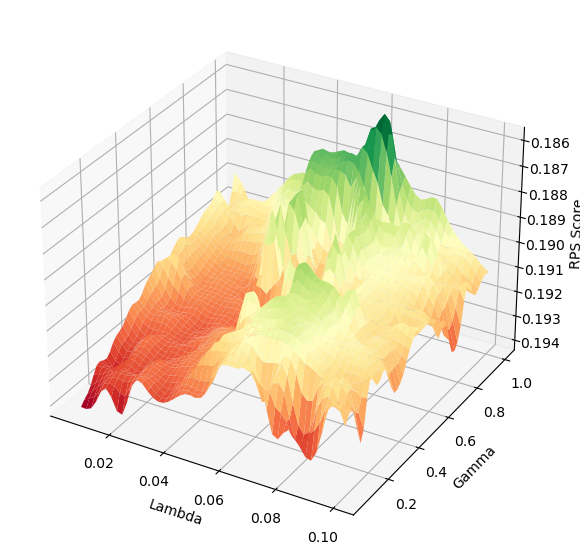

/var/folders/js/lg3nlt2956z9yc23wzld8xm80000gn/T/ipykernel_39518/4145351531.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap('RdYlGn_r')  # Reversed Red-Yellow-Green colormap


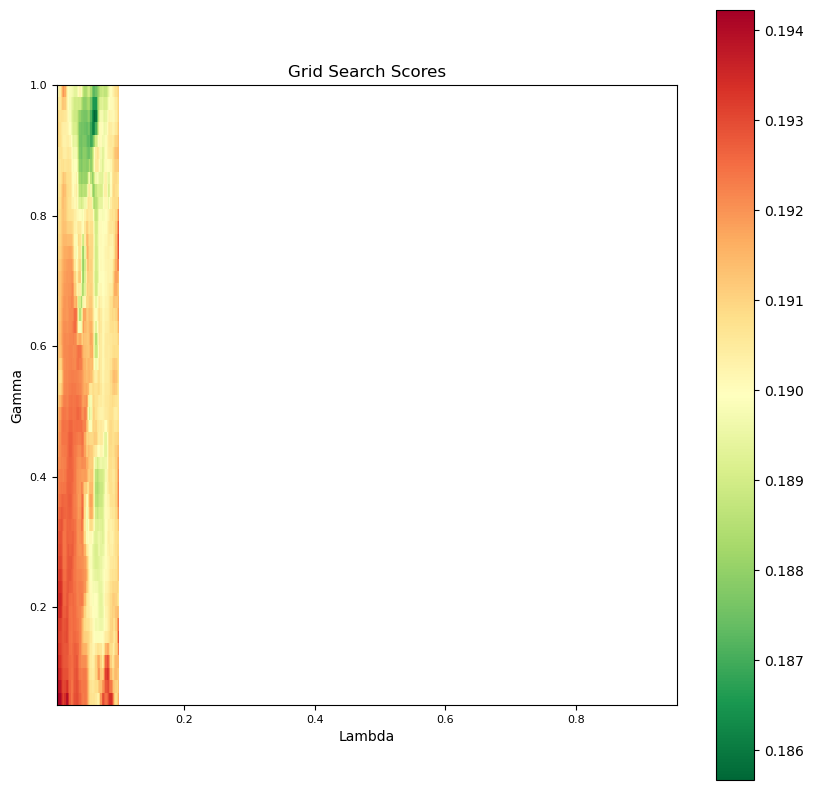

/var/folders/js/lg3nlt2956z9yc23wzld8xm80000gn/T/ipykernel_39518/4145351531.py:96: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = df_gs_results.pivot('learning_rate_lambda', 'learning_rate_gamma', 'score')


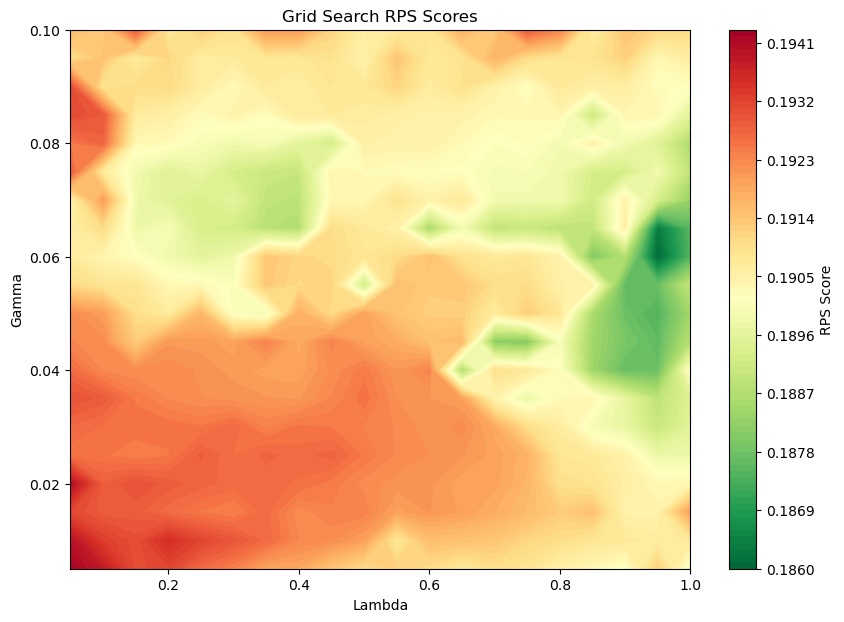

''

In [772]:

# Define a parameter grid with the ranges for your parameters
param_grid = {
    'learning_rate_lambda': np.arange(0.005, 0.101, 0.005),
    'learning_rate_gamma': np.arange(0.05, 1.01, 0.05)
}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable and best_params dictionary
best_score = float('inf')  # assuming lower scores are better; use -float('inf') if higher scores are better
best_params = {}

# Create an empty list to store the results
gs_results = []

# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    ratings = initialize_ratings(df_results, df_fixtures)

    # Update your learning rates
    learning_rate_lambda = params['learning_rate_lambda']
    learning_rate_gamma = params['learning_rate_gamma']

    # Re-train model with the new parameters
    ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, learning_rate_lambda, learning_rate_gamma)

    df_train = pd.DataFrame(training_games)
    df_train.to_csv("../data/train.csv", index=False)
    model = train_model(df_train)

    all_rps, league_table = predict_outcomes(df_fixtures, ratings, learning_rate_lambda, learning_rate_gamma)
    score = np.mean(all_rps)  # Assuming score is calculated like this

    # If the current score is better than the best_score, update best_score and best_params
    if score < best_score:
        best_score = score
        best_params = params

    # Store the current score and parameters
    gs_results.append({
        'learning_rate_lambda': learning_rate_lambda,
        'learning_rate_gamma': learning_rate_gamma,
        'score': score,
    })

print(f'Best score: {best_score}')
print(f'Best params: {best_params}')

# Convert the gs_results to a DataFrame and plot them
df_gs_results = pd.DataFrame(gs_results)

# Define grid of x, y values
lambda_range = np.linspace(df_gs_results['learning_rate_lambda'].min(), df_gs_results['learning_rate_lambda'].max(), num=50)
gamma_range = np.linspace(df_gs_results['learning_rate_gamma'].min(), df_gs_results['learning_rate_gamma'].max(), num=50)
lambda_grid, gamma_grid = np.meshgrid(lambda_range, gamma_range)

# Interpolate z values for this grid
rps_grid = griddata((df_gs_results['learning_rate_lambda'], df_gs_results['learning_rate_gamma']), df_gs_results['score'], (lambda_grid, gamma_grid), method='cubic')

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(lambda_grid, gamma_grid, rps_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel('Lambda')
ax.set_ylabel('Gamma')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
#fig.colorbar(surf)
plt.savefig("../images/3d_plot_gs.png", dpi=300)
plt.show()

# Create 2D plot with colormap
plt.figure(figsize=(10, 10))  # Adjust figsize to your preference to make the plot square
plt.title('Grid Search Scores')

cmap_reversed = plt.cm.get_cmap('RdYlGn_r')  # Reversed Red-Yellow-Green colormap

# Here we store the image object returned by imshow
im = plt.imshow(rps_grid, interpolation='nearest', cmap=cmap_reversed,
           extent=(param_grid['learning_rate_lambda'].min(), param_grid['learning_rate_lambda'].max(), param_grid['learning_rate_gamma'].min(), param_grid['learning_rate_gamma'].max()), origin='lower')

# We use the stored image object for the colorbar
plt.colorbar(im, cmap=cmap_reversed)

plt.axis('square')  # This will enforce a square aspect ratio

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Lambda")
plt.ylabel("Gamma")
plt.savefig("../images/2d_plot_heat_gs.png", dpi=300)
plt.show()

# Convert grid search results into a pivot table for plotting
pivot_table = df_gs_results.pivot('learning_rate_lambda', 'learning_rate_gamma', 'score')

# Create contour plot
plt.figure(figsize=(10,7))
contour_plot = plt.contourf(pivot_table.columns, pivot_table.index, pivot_table.values, cmap='RdYlGn_r', levels=100)
plt.title('Grid Search RPS Scores')
plt.xlabel('Lambda')
plt.ylabel('Gamma')

# Add a colorbar
cbar = plt.colorbar(contour_plot)
cbar.ax.set_ylabel('RPS Score')

plt.savefig("../images/2d_plot_contour_gs.png", dpi=300)
plt.show()

;